## Imports

In [1]:
# Python Modules
# --------------------------------------------------
import os
import cv2
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib.image  as mpimg


# Torch Modules
# --------------------------------------------------
import torch


# Custom Modules
# --------------------------------------------------
import utils
import config

from models import Net

## Load Image

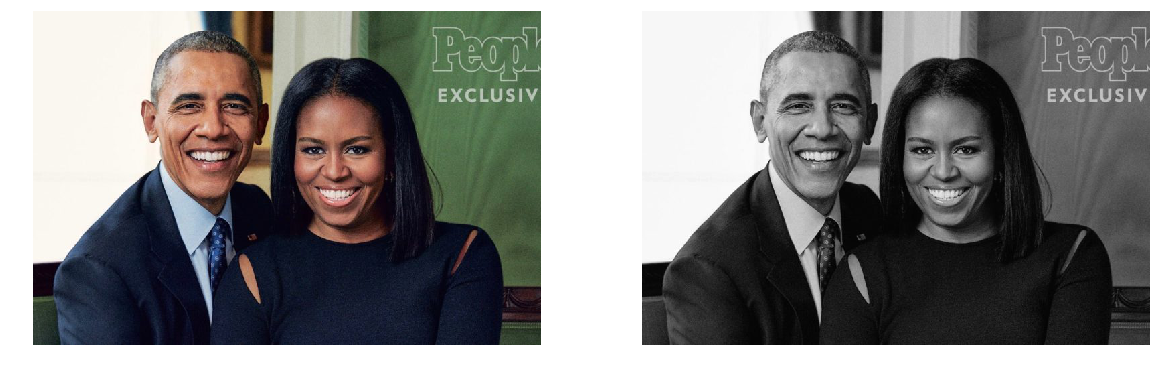

In [2]:
# Load Image
# --------------------------------------------------
image      = cv2.imread(config.TEST_IMAGE_PATH)
image      = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)


# Visualize
# --------------------------------------------------
fig, axs = plt.subplots(1, 2, figsize = (20, 8))

axs[0].imshow(image)
axs[0].axis("off")

axs[1].imshow(image_gray, cmap = "gray")
axs[1].axis("off")

None

## Detect Haar Features

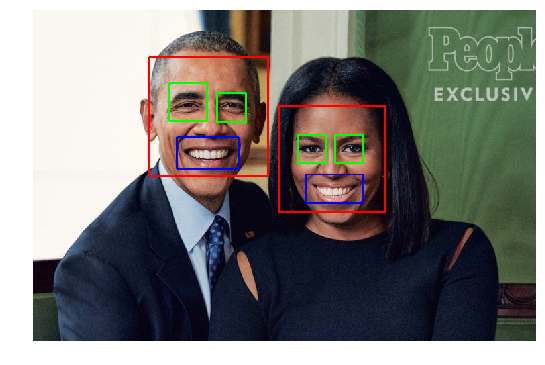

In [3]:
# Load Haar Cascades
# --------------------------------------------------
face_cascade  = cv2.CascadeClassifier(f"{config.HAAR_CASCADE_DIR}/{config.HAAR_FACE_FILENAME}")
eye_cascade   = cv2.CascadeClassifier(f"{config.HAAR_CASCADE_DIR}/{config.HAAR_EYE_FILENAME}")
smile_cascade = cv2.CascadeClassifier(f"{config.HAAR_CASCADE_DIR}/{config.HAAR_SMILE_FILENAME}")


# Detect Facial Features
# --------------------------------------------------
faces = face_cascade.detectMultiScale(
    image        = image_gray, 
    scaleFactor  = config.FACE_SCALE_FACTOR, 
    minNeighbors = config.FACE_MIN_NEIGHBORS
)

image_with_detections = image.copy()



# Faces
# --------------------------------------------------
for (fx, fy, fw, fh) in faces:
    cv2.rectangle(
        img       = image_with_detections, 
        pt1       = (fx, fy), 
        pt2       = (fx + fw, fy + fh), 
        color     = (255, 0, 0), 
        thickness = 2
    ) 
    
    roi_gray  = image_gray[fy:fy + fh, fx:fx + fw]
    roi_color = image[     fy:fy + fh, fx:fx + fw]
    
    
    # Eyes
    # --------------------------------------------------
    eyes = eye_cascade.detectMultiScale(
        image        = roi_gray, 
        scaleFactor  = config.EYE_SCALE_FACTOR, 
        minNeighbors = config.EYE_MIN_NEIGHBORS
    )
    
    for (ex, ey, ew, eh) in eyes:
        cv2.rectangle(
            img       = image_with_detections, 
            pt1       = (fx + ex, fy + ey), 
            pt2       = (fx + ex + ew, fy + ey + eh), 
            color     = (0, 255, 0), 
            thickness = 2
        ) 
       
    
    # Smiles
    # --------------------------------------------------
    smiles = smile_cascade.detectMultiScale(
        image        = roi_gray, 
        scaleFactor  = config.SMILE_SCALE_FACTOR,  
        minNeighbors = config.SMILE_MIN_NEIGHBORS
    )
    
    for (sx, sy, sw, sh) in smiles:
        cv2.rectangle(
            img       = image_with_detections, 
            pt1       = (fx + sx, fy + sy), 
            pt2       = (fx + sx + sw, fy + sy + sh), 
            color     = (0, 0, 255), 
            thickness = 2
        )

    
# Visualize Result
# --------------------------------------------------
fig = plt.figure(figsize = (9, 9))

plt.imshow(image_with_detections)
plt.axis("off")

None

## Load Network

In [4]:
if os.path.isfile(f"{config.MODEL_DIR}/{config.MODEL_NAME}"): 
    net = Net()
    
    net.load_state_dict(torch.load(f"{config.MODEL_DIR}/{config.MODEL_NAME}"))
    net.eval()
    
    print(net)
    
else:
    print(f"[ERROR] network not found: {config.MODEL_DIR}/{config.MODEL_NAME}")

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout(p=0.1)
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop2): Dropout(p=0.2)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop3): Dropout(p=0.3)
  (conv4): Conv2d(128, 256, kernel_size=(2, 2), stride=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop4): Dropout(p=0.4)
  (conv5): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
  (pool5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop5): Dropout(p=0.5)
  (fc1): Linear(in_features=9216, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True

## Find Keypoints for Haar Faces

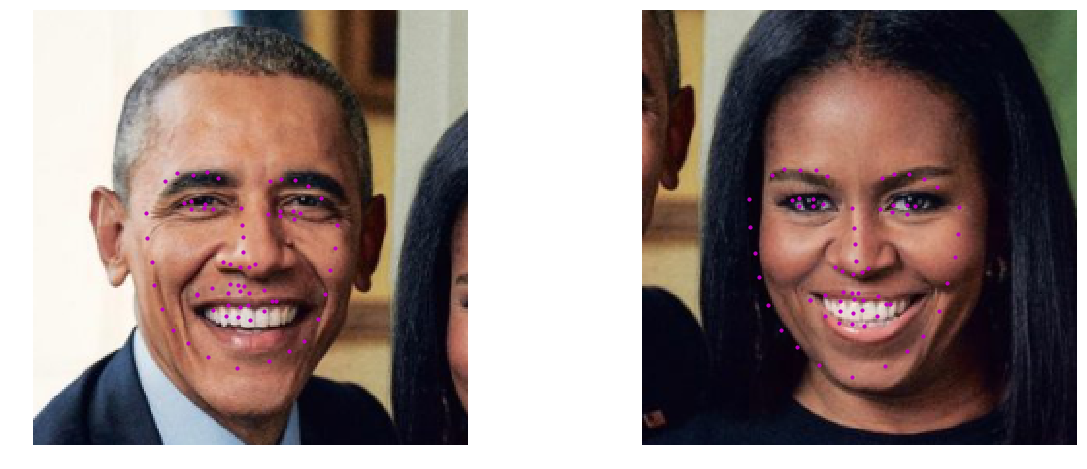

In [5]:
# Initialize Visual
# --------------------------------------------------
fig, axs = plt.subplots(1, 2, figsize = (20, 8))


# Predict and Plot Keypoints for Detected Faces
# --------------------------------------------------
for idx, (x, y, w, h) in enumerate(faces):
    
    
    # Get ROI
    # --------------------------------------------------
    roi = image[
        y - config.HAAR_PADDING : y + h + config.HAAR_PADDING,
        x - config.HAAR_PADDING : x + w + config.HAAR_PADDING
    ]
    
    
    # Preprocess Image
    # --------------------------------------------------
    roi = utils.rescale_numpy(roi)
    roi = utils.random_crop_numpy(roi)
    
    roi_np = np.copy(roi)
    
    roi = utils.normalize_numpy(roi)
    roi = utils.to_tensor_numpy(roi)
    
    
    # Get Keypoints
    # --------------------------------------------------
    keypoints = utils.predict(
        model = net, 
        image = roi
    )

       
    # Visualize Keypoints
    # --------------------------------------------------
    axs[idx].imshow(roi_np, cmap = 'gray')
    axs[idx].scatter(
        keypoints[:, 0], 
        keypoints[:, 1], 
        s      = 40, 
        marker = ".", 
        c      = "m"
    )
    
    axs[idx].axis('off')
    
    None